# Circle fitting 2D
Reference:
- [least squares circle fit.pdf](https://dtcenter.org/met/users/docs/write_ups/circle_fit.pdf) (PDF1)
- [Least squares circle](http://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as linalg

## data 

Text(0,0.5,'y')

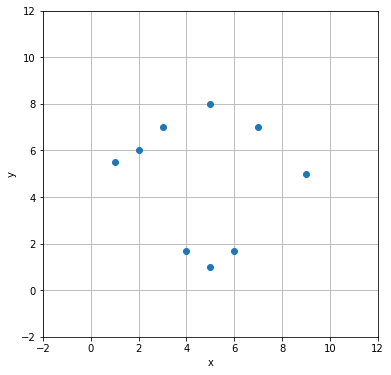

In [18]:
# data
points = np.array([[1, 2, 5, 7, 9, 3, 5, 4, 6],
                   [5.5, 6, 8, 7, 5, 7, 1, 1.7, 1.7]])
x = points[0]
y = points[1]

fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, 'o')
plt.grid(True)
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.xlabel('x')
plt.ylabel('y')

## least squares circle fit: algebraic method
see PDF1
Find three parameters $\{x_c, y_c, R\}$ such that the following cost function is minimized
\begin{equation}
J = \sum_i \big( (x_i - x_c)^2 + (y_i - y_c)^2 - R^2 \big)^2
\end{equation}
To simplify the computation, the data points are first centered to have a mean of zero on each dimension, and define $\alpha = R^2$.

In [19]:
u = x - np.mean(x)
v = y - np.mean(y)
Suu = np.sum(u ** 2)
Suv = np.sum(u * v)
Svv = np.sum(v ** 2)
Suuu = np.sum(u ** 3)
Suvv = np.sum(u * v * v)
Svvv = np.sum(v ** 3)
Svuu = np.sum(v * u * u)

In [20]:
# Eq. 4 & 5 in PDF1
left = np.array([[Suu, Suv], [Suv, Svv]])
right = np.array([(Suuu + Suvv) / 2, (Svvv + Svuu) / 2])
# left * ans = right (matrix multiplication)
ans = linalg.inv(left).dot(right)
print(ans)

[ 0.3387264  -0.12959296]


In [21]:
# the better way is to solve linear equations instead of inversing the matrix explicitly
uc, vc = linalg.solve(left, right)
print(uc, vc)
xc = uc + np.mean(x)
yc = vc + np.mean(y)

0.3387264028915902 -0.12959295709130975


In [22]:
# Eq.6
alpha = uc ** 2 + vc**2 + (Suu + Svv) / len(u)
R = np.sqrt(alpha)
print(R)

3.4435732280888427


In [23]:
print('Result of the algebraic method: ', f'xc={xc}, yc={yc}, R={R}')

Result of the algebraic method:  xc=5.005393069558258, yc=4.637073709575358, R=3.4435732280888427


Text(0,0.5,'y')

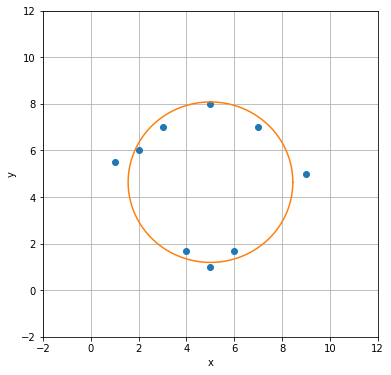

In [24]:
## visualize the results
t = np.arange(0, 2*np.pi, 0.01)
xm = R * np.cos(t) + xc
ym = R * np.sin(t) + yc

fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, 'o')
plt.plot(xm, ym)
plt.grid(True)
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.xlabel('x')
plt.ylabel('y')


## Solve with scipy.linalg: use another objectve to minimize the geometric distance
A different objective can be adopted to first neglect $R$. We know that if the points are on a circle, then $r=\sqrt{(x_i - x_c)^2 + (y_i - y_c)^2}$ should give the same value, i.e., $R$. Thus, compute this radius value for each point, and we try to find a certain pair of ${x_c, y_c}$ to minimize the variance of these $r$'s.
\begin{equation}
J = \sum_i (r - \text{mean}(r))^2
\end{equation}
**How to get the above objective?**

In fact, we want to minimize the geometric distances from the points to the circle, defined as $||\sqrt{(x_i - x_c)^2 + (y_i - y_c)^2} - R||$. Thus, the objective is
\begin{equation}
J = \sum_i (\sqrt{(x_i - x_c)^2 + (y_i - y_c)^2} - R) ^ 2
\end{equation}
Apparently, we can separate $R$, since once the center is determined, to minimized the above objection, the solution of R is 
\begin{equation}
R = \frac{1}{N}\sum_i \sqrt{(x_i - x_c)^2 + (y_i - y_c)^2}
\end{equation}
Sustituting $R$ into the above objective, we get the objective function with only ${x_c, y_c}$.

**Comparison with the algebraic method**
The first algebraic approach try to minimizes $|(x_i - x_c)^2 + (y_i - y_c)^2 - R^2|$ with no geometric meaning, while the geometric one tries to minimize $|\sqrt{(x_i - x_c)^2 + (y_i - y_c)^2} - R|$. 

>> **The algebraic approximation gives good results when the points are all around the circle but is limited when there is only an arc to fit.** Indeed, the two errors functions to minimize are not equivalent when data points are not all exactly on a circle. The algebraic method leads in most of the case to a smaller radius than that of the least squares circle, as its error function is based on squared distances and not on the distance themselves. 
(http://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html)

To solve the nonlinear problem above, the [`scipy.optimize.leastsq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html) can be used.

`scipy.optimize.leastsq(func, x0)`
where `func` accepts a parameter vector of the same length as `x0` and returns N floating point numbers, usually a 1d array, say $e_1, e_2, \cdots, e_N = func(\cdot)$.  
\begin{equation}
min \sum_i^N e_i^2
\end{equation}


In [25]:
def compute_r(c):
    """
    c is the circle center to be evaluated.
    Return a list of radii correponding to each point.
    """
    r = np.sqrt((x - c[0]) ** 2 + (y - c[0]) ** 2)
    return r

In [26]:
def cost(c):
    """
    c is the circle center to be evaluated.
    """
    r = compute_r(c)
    return r - r.mean()

In [27]:
import scipy.optimize as optimize
# initial guess
x0 = np.array([x.mean(), y.mean()])
center, found = optimize.leastsq(cost, x0)
if found in [1, 2, 3, 4]:
    print('Found center: ', center)

Found center:  [4.78222048 4.76666667]


In [28]:
R2 = compute_r(center).mean()
print('R = ', R2)
xc2, yc2 = center

R =  3.3999303221204933


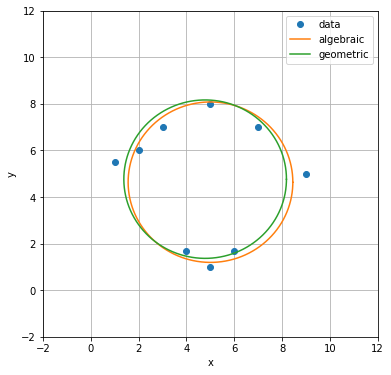

In [29]:
## visualize the results
t = np.arange(0, 2*np.pi, 0.01)
xm = R * np.cos(t) + xc
ym = R * np.sin(t) + yc
xm2 = R2 * np.cos(t) + xc2
ym2 = R2 * np.sin(t) + yc2

fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, 'o')
plt.plot(xm, ym)
plt.plot(xm2, ym2)
plt.grid(True)
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['data', 'algebraic', 'geometric'])